<a target="_blank" href="https://colab.research.google.com/github/tcapraz/SOFA/blob/main/docs/notebooks/depmap_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

In [2]:
# Install SOFA + dependencies
!pip install --quiet biosofa

In [2]:
!wget https://figshare.com/s/d8b7f3621b625932bfb2

In [4]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("/home/capraz/hubershare/SOFA")
import pandas as pd
import sofa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from muon import MuData
import muon as mu
from sklearn.manifold import TSNE
import scanpy as sc
import anndata as ad
from anndata import AnnData
import torch

# Introduction

In this notebook we will explore how `SOFA` can be used to analyze multi-omics data from the DepMap [[1,2,3,4,5]](#1,#2,#3,#4,#5). 
Here we give a brief introduction what the SOFA model does and what it can be used for. For a more 
detailed description please refer to our preprint: https://doi.org/10.1101/2024.10.10.617527 


## The SOFA model
Given a set of real-valued data
matrices containing multi-omic measurements from overlapping samples (also called views),
along with sample-level guiding variables that capture additional properties such as batches
or mutational profiles, SOFA extracts an interpretable lower-dimensional data representation,
consisting of a shared factor matrix and modality-specific loading matrices. The goal of these 
factors is to explain the major axes of variation in the data. SOFA explicitly assigns a subset of factors 
to explain both the multi-omics data and the guiding
variables (guided factors), while preserving another subset of factors exclusively
for explaining the multi-omics data (unguided factors). Importantly, this feature allows the
analyst to discern variation that is driven by known sources from novel, unexplained sources
of variability.

### Interpretation of the factors (Z)
Analogous to the interpretation of factors in PCA, SOFA factors ordinate samples along a
zero-centered axis, where samples with opposing signs exhibit contrasting phenotypes along
the inferred axis of variation, and the absolute value of the factor indicates the strength of the
phenotype. Importantly, SOFA partitions the factors of the low-rank decomposition into
guided and unguided factors: the guided factors are linked to specific guiding variables,
while the unguided factors capture global, yet unexplained, sources of variability in the data. 
The factor values can be used in downstream analysis tasks related to the samples, such as clustering 
or survival analysis. The factor values are called Z in SOFA.

### Interpretation of the loading weights (W)
SOFA’s loading weights indicate the importance of each feature for its respective factor,
thereby enabling the interpretation of SOFA factors. Loading weights close to zero indicate
that a feature has little to no importance for the respective factor, while large magnitudes
suggest strong relevance. The sign of the loading weight aligns with its corresponding factor,
meaning that positive loading weights indicate higher feature levels in samples with positive
factor values, and negative loading weights indicate higher feature levels in samples with
negative factor values. The top loading weights can be simply inspected or used in downstream analysis such as gene set 
enrichment analysis. The factor values are called W in SOFA.

### Supported data
SOFA expects a set of matrices containing omics measurements with matching and aligned samples and different features. 
Currently SOFA only supports Gaussian likelihoods, for the multi-omics data. 
Data should therefore be appropriately normalized according to
its omics modality. Additionally, data should be centered and scaled.


For the guiding variables SOFA supports Gaussian, Bernoulli and Categorical likelihoods. Guiding variables
can therefore be continuous, binary or categorical. Guiding variables should be vectors with matching samples with 
the multi-omics data.

In SOFA the multi-omics data is denoted as X and the guiding variables as Y.


## The DepMap data set
The DepMap project aims to identify cancer vulnerabilities and drug targets across a diverse range of cancer types. The data set includes multi-omics data, encompassing transcriptomics[[4]](#4), proteomics[[1]](#1), and methylation[[5]](#5), as well as drug response profiles for 627 drugs[[5]](#5) and CRISPR-Cas9 gene essentiality scores[[2,3]](#2,#3) for 17485 genes for 949 cancer cell lines across 26 different tissues. We will fit a SOFA model with 20 factors, while accounting for potential/known drivers of variation such as growth rate, microsatellite instability (MSI) status, BRAF, TP53 and PIK3CA mutation and hematopoietic lineage. We will use the essentiality score data test factor associations with essentiality scores.
We will first load the preprocessed data in `MuData` format, fit a SOFA model and perform various downstream analyses. 



<a id="1">[1]</a> 
Gonçalves, E. et al. Pan-cancer proteomic map of 949 human cell lines. Cancer Cell 40, 835–849.e8 (2022).\
<a id="2">[2]</a> 
Boehm, J. S. et al. Cancer research needs a better map. Nature 589, 514–516 (2021).\
<a id="3">[3]</a> 
Pacini, C. et al. Integrated cross-study datasets of genetic dependencies in cancer. Nat. Commun. 12, 1661 (2021).\
<a id="4">[4]</a> 
Garcia-Alonso, L. et al. Transcription factor activities enhance markers of drug sensitivity in cancer. Cancer Res. 78, 769–780 (2018).\
<a id="5">[5]</a> 
Iorio, F. et al. A landscape of pharmacogenomic interactions in cancer. Cell 166, 740–754 (2016).

# Read data and set hyperparameters

In [9]:
# First we read the preprocessed data as a single MuData object
mdata = mu.read("pancan_depmap.h5mu")
mdata

MuData object with n_obs × n_vars = 778 × 23503
  obs:	'DepMap_ID', 'cell_line_name', 'stripped_cell_line_name', 'CCLE_Name', 'alias', 'COSMICID', 'sex', 'source', 'RRID', 'WTSI_Master_Cell_ID', 'sample_collection_site', 'primary_or_metastasis', 'primary_disease', 'Subtype', 'age', 'Sanger_Model_ID', 'depmap_public_comments', 'lineage', 'lineage_subtype', 'lineage_sub_subtype', 'lineage_molecular_subtype', 'default_growth_pattern', 'model_manipulation', 'model_manipulation_details', 'patient_id', 'parent_depmap_id', 'Cellosaurus_NCIt_disease', 'Cellosaurus_NCIt_id', 'Cellosaurus_issues', 'model_id', 'Project_Identifier', 'Cell_line', 'Source', 'Identifier', 'Gender', 'Tissue_type', 'Cancer_type', 'Cancer_subtype', 'Haem_lineage', 'BROAD_ID', 'CCLE_ID', 'ploidy', 'mutational_burden', 'msi_status', 'growth_properties', 'growth', 'size', 'media', 'replicates_correlation', 'number_of_proteins', 'EMT', 'Proteasome', 'TranslationInitiation', 'CopyNumberInstability', 'GeneExpressionCorrelation', 'CopyNumberAttenuation', 'crispr_source', 'hema/lymph'
  12 modalities
    RNA:	778 x 2000
      uns:	'llh', 'log1p'
      obsm:	'mask'
    Protein:	778 x 2000
      uns:	'llh'
      obsm:	'mask'
    Methylation:	778 x 2000
      uns:	'llh', 'log1p'
      obsm:	'mask'
    Drug response:	778 x 627
      uns:	'llh'
      obsm:	'mask'
    CRISPR scores:	778 x 16258
      uns:	'llh'
      obsm:	'mask'
    Mutations:	778 x 612
      uns:	'llh'
      obsm:	'mask'
    Growth:	778 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    MSI:	778 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    BRAF:	778 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    TP53:	778 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    PIK3CA:	778 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    Hema:	778 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'

The mdata object contains 12 data modalities and the obs slot contains metadata of the cell lines. 
We will use RNA, Protein, Methylation and Drug response as the multi-omics data input for `SOFA`. 
We will use the modalities Growth (the growth rate of the cell lines), MSI (microsatellite instability status), BRAF (whether the cell line is mutated in BRAF), TP53 
(whether the cell line is mutated in TP53), PIK3CA (whether the cell line is mutated in PIK3CA) and Hema (whether the cell line is from the 
hematopoietic lineage) as guiding variables. The modalities Mutations and CRISPR scores will be used in the downstream analysis, to test for significant associations with factors.

In [ ]:
# We create the MuData object Xmdata, which contains the multi-omics data:
Xmdata = MuData({"RNA":mdata["RNA"], "Protein":mdata["Protein"], "Methylation":mdata["Methylation"], "Drug response":mdata["Drug response"]})
# We create the MuData objectYmdata, which contains the guiding variables:
Ymdata = MuData({"Growth":mdata["Growth"], "MSI": mdata["MSI"], "BRAF": mdata["BRAF"], "TP53":mdata["TP53"], "PIK3CA":mdata["PIK3CA"], "Hema": mdata["Hema"]})

## (Optional for this Tutorial) here we will show how you would prepare the input data for SOFA yourself
We assume that you have a `pandas.DataFrame` for each of the data modalities. 

In [14]:
# Extract dataframes from the `MuData` object
rna_df = mdata["RNA"].to_df()
prot_df = mdata["Protein"].to_df()
meth_df = mdata["Methylation"].to_df()
drug_df = mdata["Drug response"].to_df()

Then we can use the sofa.tl.get_ad() function to produce an appropriate `AnnData` object.

In [15]:
rna_ad = sofa.tl.get_ad(rna_df, llh = "gaussian") # currently only the Gaussian likelihood is supported for the omics data
prot_ad = sofa.tl.get_ad(prot_df, llh = "gaussian")
meth_ad = sofa.tl.get_ad(meth_df, llh = "gaussian")
drug_ad = sofa.tl.get_ad(drug_df, llh = "gaussian")
# Finally as before wrap all the `AnnData` objects in a single `MuData` object.
Xmdata = MuData({"RNA":rna_ad, "Protein":prot_ad, "Methylation":meth_ad, "Drug response":drug_ad})

and analogously for the guiding variables:

In [16]:
growth_df = mdata["Growth"].to_df()
msi_df = mdata["MSI"].to_df()
braf_df = mdata["BRAF"].to_df()
tp53_df = mdata["TP53"].to_df()
pik3ca_df = mdata["PIK3CA"].to_df()
hema_df = mdata["Hema"].to_df()

Again we can use the sofa.tl.get_ad() function to produce an appropriate `AnnData` object.
We need to specify an appropriate likelihood for each guiding variables. For the continuous growth rate we use 
`gaussian` and for the remaining binary variables `bernoulli`. SOFA also supports the `categorical` likelihood.
Additionally, we need to set a scaling factor for each guiding 
variables, determining the strength of the supervision in the fitting process. To high values lead to guided factors that do not explain any variance 
of the multi-omics data. Too low values would lead to factors that are not associated with their guiding variables.
We recommend the default of 0.1.

In [19]:
growth_ad = sofa.tl.get_ad(growth_df, llh = "gaussian", scaling_factor = 0.01) 
msi_ad = sofa.tl.get_ad(msi_df, llh = "bernoulli", scaling_factor = 0.1)
braf_ad = sofa.tl.get_ad(braf_df, llh = "bernoulli", scaling_factor = 0.1)
tp53_ad = sofa.tl.get_ad(tp53_df, llh = "bernoulli", scaling_factor = 0.1)
pik3ca_ad = sofa.tl.get_ad(pik3ca_df, llh = "bernoulli", scaling_factor = 0.1)
hema_ad = sofa.tl.get_ad(hema_df, llh = "bernoulli", scaling_factor = 0.1)

# Finally as before wrap all the `AnnData` objects in a single `MuData` object.
Ymdata = MuData({"Growth":growth_ad, "MSI": msi_ad, "BRAF": braf_ad, "TP53": tp53_ad, "PIK3CA": pik3ca_ad, "Hema": hema_ad})

In [20]:
# We set the number of factors to infer
num_factors = 20
# Use obs as metadata of the cell lines
metadata = mdata.obs
# In order to relate factors to guiding variables we need to provide a design matrix (guiding variables x number of factors) 
# indicating which factor is guided by which guiding variable.
# Here we just indicate that the first 6 factors are each guided by a different guiding variable:
design = np.zeros((len(Ymdata.mod), num_factors))
for i in range(len(Ymdata.mod)):
    design[i,i] = 1
    
# convert to torch tensor to make it usable by SOFA
design = torch.tensor(design)
design

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], dtype=torch.float64)

# Fit the `SOFA`model

In [21]:
model = sofa.SOFA(Xmdata = Xmdata, # the input multi-omics data  
                  num_factors=num_factors, # number of factors to infer
                  Ymdata = Ymdata, # the input guiding variables
                  design = design, # design matrix relating factors to guiding variables
                  device='cuda', # set device to "cuda" to enable computation on the GPU
                  seed=42) # set seed to get the same results every time we run it

In [22]:
# train SOFA with learning rate of 0.01 for 3000 steps
model.fit(n_steps=3000, lr=0.01)
# decrease learning rate to 0.005 and continue training
model.fit(n_steps=3000, lr=0.005)

Current Elbo 3.69E+06 | Delta: 494761: 100%|██████████| 3000/3000 [05:01<00:00,  9.94it/s] 
Current Elbo 2.61E+06 | Delta: -65210: 100%|██████████| 3000/3000 [04:43<00:00, 10.58it/s] 


In [6]:
# if we would like to save the fitted model we can save it using:
#sofa.tl.save_model(model,"depmap_example_model")

# to load the model use:
model = sofa.tl.load_model("depmap_example_model")

# Downstream analysis


## Convergence

We will first assess whether the ELBO loss of SOFA has converged by plotting it over training steps

Text(0, 0.5, 'ELBO')

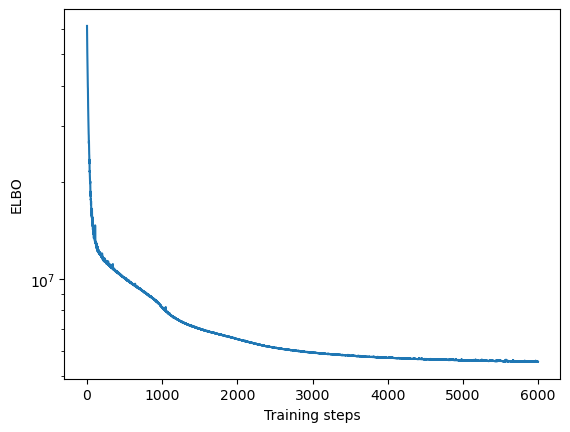

In [15]:
plt.semilogy(model.history)
plt.xlabel("Training steps")
plt.ylabel("ELBO")

## Variance explained

A good first step in a SOFA analysis is to plot how much variance is explained by each factor for each modality. This gives us an overview 
which factors are active across multiple modalities, capturing correlated variation across multiple measurements 
and which are private to a single modality, most probably capturing technical effects related to this modality.

<Axes: xlabel='View', ylabel='Factor'>

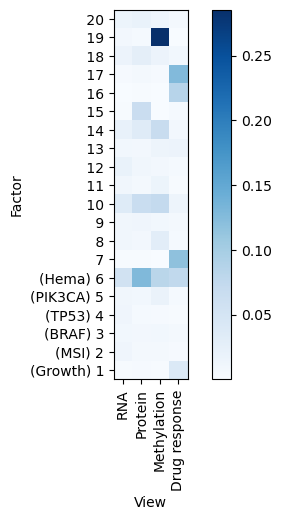

In [16]:
sofa.pl.plot_variance_explained(model)

<Axes: xlabel='View', ylabel='R2'>

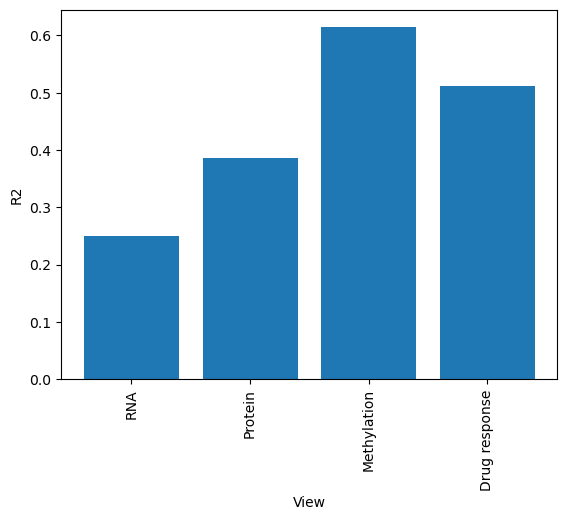

In [13]:
# We can also plot how much variance of each view is explained
sofa.pl.plot_variance_explained_view(model)

<Axes: xlabel='View', ylabel='R2'>

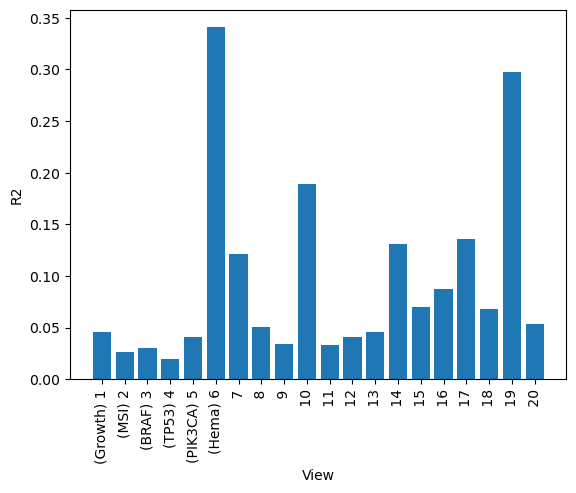

In [14]:
# or how much variance is explained by each factor in total
sofa.pl.plot_variance_explained_factor(model)

## Check factor guidance

In [23]:
# concatenate metadata with TP53, BRAF and PIK3CA mutation columns
metadata= pd.concat((metadata, mdata.mod["Mutations"].to_df()[["TP53", "BRAF", "PIK3CA"]]), axis=1)

<Axes: xlabel='Covariate', ylabel='Factor'>

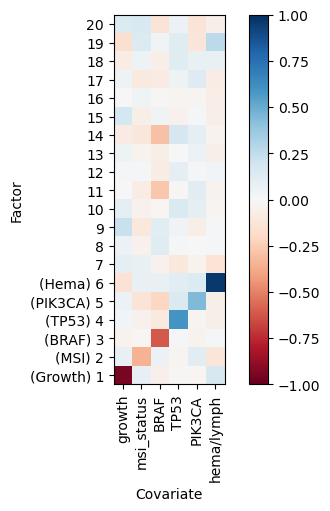

In [24]:
# plot correlation of factor values with selected metadata variables ["growth", "msi_status","BRAF","TP53",  "PIK3CA", "hema/lymph"]
sofa.pl.plot_factor_metadata_cor(model, metadata[["growth", "msi_status","BRAF","TP53",  "PIK3CA", "hema/lymph"]])

As expected the guided factors a correlated with their respective guiding variables. The unguided factors are not correlated with the guiding variables.

## Downstream analysis of the factor values

The factor values represent the new coordinates in lower dimensional space of our samples and have dimensions samples x factors. 
The factor values called Z in SOFA.
We can use the factor values for all kinds of downstream analyses on the sample level. Here we will cluster the unguided factors.

We first retrieve the factor values:

In [17]:
Z = sofa.tl.get_factors(model)
Z

Factor_0 (Growth)  Factor_1 (MSI)  Factor_2 (BRAF)  Factor_3 (TP53)  \
0            -0.984563        0.094903         1.867936         0.991292   
1            -0.674658        0.031586        -0.789824        -0.407347   
2            -0.361459       -0.191929        -0.307024         0.383602   
3            -0.605062       -0.200432        -0.299046         0.202695   
4             0.212342       -0.120816        -0.212216         0.690939   
..                 ...             ...              ...              ...   
773          -0.030411       -0.103553        -0.316009         0.223481   
774           0.561793       -0.662839         0.209959        -0.977655   
775           0.208128       -0.140388         0.508802        -0.937757   
776           1.427114       -1.299472        -0.234395        -0.894223   
777          -0.233796        0.198935         2.749278         1.159026   

     Factor_4 (PIK3CA)  Factor_5 (Hema)  Factor_6  Factor_7  Factor_8  \
0            -0.005510         0.174301 -0.149569 -0.101285  0.118306   
1             1.124087         0.458733 -0.060520 -0.040364 -0.503078   
2             0.018404         0.897071  0.294184 -0.372404  0.148475   
3             0.221496         0.108696 -0.091975  0.026284  0.158653   
4             0.186770         0.897576  0.123370  0.123256 -0.111156   
..                 ...              ...       ...       ...       ...   
773           0.244809         0.518574  0.131121 -0.026001 -0.492095   
774           0.237925         0.574140 -0.069846  0.001591 -1.813954   
775          -0.153248        -2.141505 -0.047474  0.235640  0.024192   
776           0.246734         0.601628  0.543358  0.153857 -1.782104   
777          -0.625919         0.637330 -0.659517  1.177139  0.177545   

     Factor_9  Factor_10  Factor_11  Factor_12  Factor_13  Factor_14  \
0    0.228873  -0.208032  -0.263638  -0.600392  -0.382208   0.140103   
1   -0.399277   0.166812  -0.032913   0.652486  -0.614164   0.154161   
2    0.785472  -0.204483   0.098536   0.097677   0.411425  -0.391176   
3    0.096715   0.113269  -0.056898  -0.152790   0.209436   0.354010   
4    0.608043  -0.065553   0.236904  -0.198532  -0.240049  -0.649414   
..        ...        ...        ...        ...        ...        ...   
773 -0.288541   0.167538   0.161157   0.659408  -0.443171   0.323169   
774  0.000474  -0.044735   0.296505  -0.099778   0.061658   0.567360   
775 -0.118403  -0.061317  -0.530468   0.032437  -0.095084  -0.306878   
776  0.350788   0.240557   0.425656  -0.485319   0.379114  -0.334070   
777  0.033086  -0.106065  -0.191898  -0.288880  -1.048721  -0.279230   

     Factor_15  Factor_16  Factor_17  Factor_18  Factor_19  
0     0.344184  -0.815846   0.459298   0.719330  -0.313031  
1     0.377786   0.100994  -1.004648  -0.408009   0.504229  
2     0.374827   0.386192  -0.456484   0.346030   0.550844  
3     0.336211   0.376640  -0.477210  -0.379058   0.468571  
4     0.371791   0.641309   0.105965   0.207381   0.464103  
..         ...        ...        ...        ...        ...  
773  -0.498860  -0.499177  -1.300491   0.662859   0.273217  
774   0.424479  -0.512040   1.120325  -0.449671  -1.028471  
775  -0.375194   0.274054   0.427416  -1.491817   0.362090  
776  -0.889224   0.031068   0.376890  -0.444826  -0.905731  
777   0.333567   0.657307   0.193587   2.300986  -0.597988  

[778 rows x 20 columns]

We will plot a tSNE of all the factors and color them by cancer type:

In [18]:
tsne = TSNE()
tsne_z = tsne.fit_transform(model.Z)

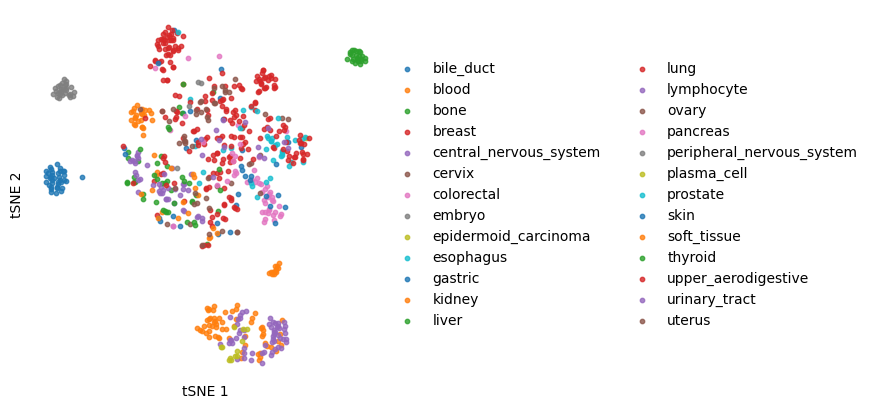

In [19]:
fig,ax = plt.subplots(1)

for i in np.unique(metadata["lineage"].astype(str)):
    ax.scatter(tsne_z[metadata["lineage"].astype(str)==i,0],tsne_z[metadata["lineage"].astype(str)==i,1], s =10, alpha=0.8,label=i)
ax.set_aspect("equal")
ax.set_xlabel("tSNE 1")
ax.set_ylabel("tSNE 2")
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False, 
    left=False,# ticks along the top edge are off
    labelbottom=False,
labelleft=False,)
ax.spines[['top','right','left','bottom']].set_visible(False)
ax.legend(frameon=False, ncols=2, loc="center left",bbox_to_anchor=(1,0.5))
          

## Downstream analysis of loading weights

The loadings capture the importance of the features in each omics modality for each factor, they have dimensions: factors x features. To retrieve the loadings run:

In [9]:
# specify the view of which we want to retrieve the loadings
W = sofa.tl.get_loadings(model, view="RNA")
W

symbol       A2M   AADACL2   AADACL3      AARD  ABCB10P1    ABI3BP      ACAN  \
0       0.015295  0.071497  0.035568  0.089748 -0.044069  0.073249  0.057849   
1      -0.034314 -0.000051  0.023871 -0.097714  0.070291 -0.047070  0.091474   
2      -0.321572  0.045532  0.004737 -0.070684 -0.024462 -0.011495 -0.150803   
3      -0.009988 -0.003648  0.012213  0.121117  0.031789 -0.031690 -0.033959   
4      -0.104526  0.066071  0.052031  0.007025  0.083235  0.038949 -0.075813   
5       0.102369  0.060284  0.038335  0.013700 -0.111408  0.278752  0.066290   
6      -0.177834 -0.042088  0.000444  0.010341  0.108204  0.005978  0.027057   
7       0.064315 -0.179968  0.041989 -0.258878 -0.158774  0.052421  0.052402   
8       0.022922  0.312208  0.010867 -0.191499  0.106837 -0.229320 -0.008715   
9      -0.307194  0.043982  0.100535 -0.267381 -0.050292 -0.010615 -0.169009   
10     -0.460474 -0.161775  0.248694  0.026441  0.160128  0.045803 -0.233451   
11     -0.011533  0.112840  0.052935 -0.015447 -0.496742 -0.003645  0.026647   
12      0.245613  0.296580 -0.038640 -0.305640 -0.124200  0.271039  0.256376   
13     -0.660592  0.019101 -0.120316 -0.134759 -0.079046 -0.341223 -0.456594   
14     -0.085970 -0.005224 -0.109311 -0.124855  0.053398  0.029236 -0.034264   
15     -0.010765 -0.039279 -0.028720  0.005197 -0.021794 -0.020378  0.005175   
16     -0.102186  0.118045  0.007831  0.033710  0.026295 -0.103503 -0.186066   
17     -0.133406  0.200971  0.115494  0.210792  0.246593 -0.616548 -0.265424   
18     -0.031818  0.005847  0.032746 -0.134567  0.327935  0.030983 -0.019491   
19     -0.600847  0.053716  0.075986 -0.049103  0.048417  0.555588 -0.332565   

symbol     ACKR3      ACP3     ACTA2  ...      XBP1      XCL2    ZNF683  \
0       0.014150 -0.007009 -0.008777  ... -0.029756  0.015113  0.042406   
1      -0.057706 -0.268044 -0.026221  ... -0.037763  0.029878  0.045231   
2       0.258310 -0.023645  0.054582  ...  0.071099  0.111338  0.020180   
3       0.002975 -0.057448 -0.136400  ... -0.068956  0.031779  0.245507   
4       0.105265  0.076275  0.093963  ... -0.027402  0.041936  0.013638   
5       0.134587 -0.168386  0.098990  ... -0.064056 -0.045495 -0.201629   
6      -0.006823 -0.105048 -0.166809  ...  0.147754 -0.021945  0.199206   
7      -0.184161 -0.064313 -0.016940  ...  0.120286 -0.008686 -0.231400   
8      -0.210733  0.037657  0.062167  ...  0.085694  0.040236 -0.080379   
9       0.112214  0.375080 -0.178900  ...  0.012742 -0.063244 -0.010274   
10     -0.090797  0.112407  0.233218  ...  0.098966 -0.276042 -0.014679   
11      0.325467 -0.001202  0.038805  ...  0.125546 -0.109403 -0.441826   
12      0.541047  0.342560  0.444382  ...  0.560416 -0.040864 -0.018886   
13     -0.103917  0.044514 -0.499875  ...  0.023534  0.128351 -0.001446   
14     -0.209597  0.003543 -0.030162  ...  0.104430 -0.231496 -0.059287   
15      0.006982  0.017629 -0.019821  ... -0.011246  0.008254  0.046750   
16     -0.038786  0.027735 -0.093989  ... -0.233836  0.137448  0.046462   
17      0.108277  0.383489 -0.634510  ...  0.005781  0.341722 -0.029150   
18      0.083426  0.073085 -0.001174  ... -0.062192  0.260967 -0.008846   
19      0.418213 -0.372007  0.248540  ... -0.052842  0.318683 -0.009427   

symbol    ZNF723     ZNRF4       ZP2       ZP4     ZPLD1   ZSCAN10  ZSWIM5P3  
0       0.026360  0.010476 -0.007051 -0.005228 -0.024504  0.009037  0.015518  
1      -0.062290 -0.131012 -0.080212 -0.024728 -0.048543  0.021252 -0.004852  
2      -0.049511 -0.059965  0.063550 -0.019318  0.126384  0.001582  0.015054  
3       0.027935  0.038758 -0.057646 -0.054516 -0.055807 -0.005945 -0.003330  
4       0.020756  0.009367  0.003728  0.026330  0.006912  0.076745 -0.143186  
5      -0.056866 -0.007317 -0.084082 -0.051703  0.098773 -0.122135 -0.010227  
6       0.040381 -0.033136 -0.052512  0.018241 -0.003154  0.250065 -0.082886  
7       0.272920 -0.021050  0.109255  0.118702  0.021676 -0.181603 -0.013686  
8      -0.042302  0.103474 -0.31

<Axes: xlabel='-log10 adjusted p-values', ylabel='Terms'>

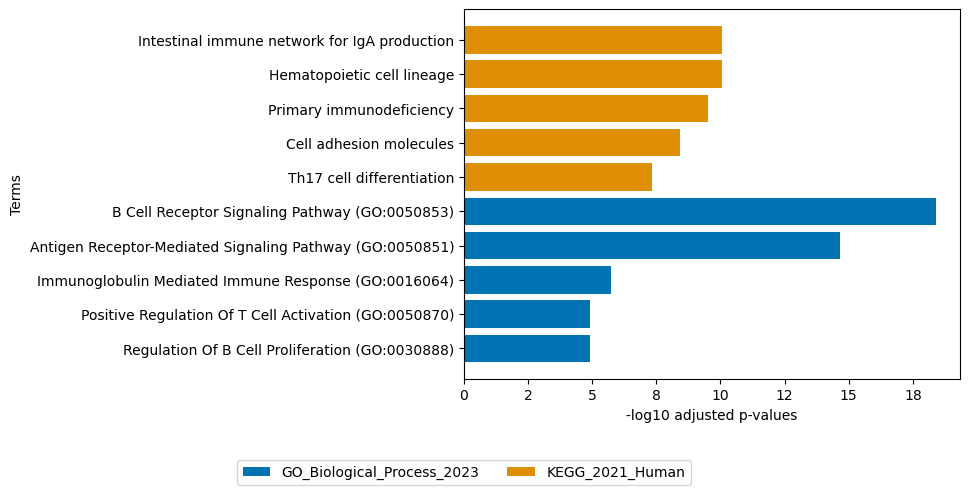

In [ ]:
# to get the names of the top 100 negative loadings of factor 5 (guided by hematopoietic lineage) of the RNA modality run:
top_loadings = sofa.tl.get_top_loadings(model, view="RNA", factor = 6, top_n=100, sign="-")
# this can be useful to perform gene overrepresentation analysis:
sofa.pl.plot_enrichment(top_loadings, # the top features
                        background=mdata.mod["RNA"].var, # all genes considered in the analysis, used as background
                        db=["GO_Biological_Process_2023", "KEGG_2021_Human"], # a list of databases for overrepresentation analysis,  
                        top_n=[5,5]) # the number of genesets for each database to plot
# sofa.pl.plot_enrichment uses the enrichr API, please refer to https://maayanlab.cloud/Enrichr/#libraries for a full list of available databases

As expected Factor 5 guided by the hematopoietic lineage captured genesets related to the immune system and the hematopoietic lineage.\
Additionally, we can also plot the top loadings weights:

<Axes: xlabel='Loadings', ylabel='Features'>

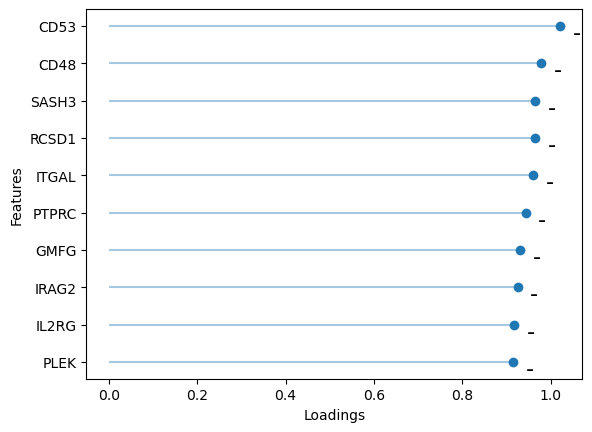

In [8]:
sofa.pl.plot_top_loadings(model, view="RNA", factor = 5, top_n=10, sign="-")